In [1]:
import pandas as pd
import random
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from geopy.distance import geodesic

In [2]:
data = []
stations_df = pd.read_csv('london/underground_stations.csv') 

for i in range(len(stations_df)):
    for j in range(i+1, len(stations_df)):
        station1 = stations_df.iloc[i]
        station2 = stations_df.iloc[j]
        coords_1 = (station1['latitude'], station1['longitude'])
        coords_2 = (station2['latitude'], station2['longitude'])
        distance = geodesic(coords_1, coords_2).km
        data.append((station1['name'], station2['name'], distance))
df = pd.DataFrame(data, columns=['start_station','end_station','distance'])

# stratified sampling
desc = df['distance'].describe()
bins = [0,desc['25%'], desc['50%'],desc['75%'],float('inf')]
labels = ['near', 'medium', 'far','very_far']
df['distance_category'] = pd.cut(df['distance'], bins=bins, labels=labels)

# Sampling from each stratum
samples = []
for label in labels:
    subset = df[df['distance_category'] == label]
    sample = subset.sample(n=25, replace=False) 
    samples.append(sample)
final_sample = pd.concat(samples)
final_sample

,start_station,end_station,distance,distance_category
7591,Bond Street,Canada Water,7.113887,near
15789,Ealing Broadway,Ealing Common,1.095574,near
9176,Brent Cross,St. John's Wood,5.410649,near
4912,Bayswater,Parsons Green,4.195661,near
27258,Holland Park,South Kensington,2.687397,near
...,...,...,...,...
27564,Hornchurch,Kentish Town,24.875381,very_far
44153,Upminster,Ruislip Gardens,45.861081,very_far
16766,Eastcote,Deptford Bridge,28.440047,very_far
1101,All Saints,Ruislip Manor,28.574960,very_far


In [3]:
algorithms = ['astar', 'dijkstra', 'bellman_ford', 'spfa','ucs']
results = []
for i in range(len(final_sample)):
    for algorithm in algorithms:
        command = f"python find_shortest_path.py \"{final_sample.iloc[i,0]}\" \"{final_sample.iloc[i,1]}\" --algorithm {algorithm}"
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        output_lines = result.stdout.strip().split('\n')
        time_info = output_lines[0]
        time_part = time_info.split(':')[1].strip()
        path_info = output_lines[-2]
        path_part = path_info.split(':')[1].strip()
        distance_info = output_lines[-1]
        distance_part = distance_info.split(':')[1].strip()
        expanded_info = output_lines[1]
        expanded_notes = expanded_info.split(':')[1].strip()
        
        result_dict = {
            'Algorithm': algorithm,
            'Start Station': final_sample.iloc[i,0],
            'End Station': final_sample.iloc[i,1],
            'Time': time_part,
            'Expanded Notes':expanded_notes,
            'Path':path_part,
            'Distance': distance_part
        }
        results.append(result_dict)

results_df = pd.DataFrame(results)
results_df.to_csv('algorithm_results_with_info.csv', index=False)

In [61]:
if results_df['Distance'].dtype == 'O':
    results_df['Distance'] = results_df['Distance'].str.replace(' km', '')
results_df['Distance'] = pd.to_numeric(results_df['Distance'], errors='coerce')
results_df['Time'] = pd.to_numeric(results_df['Time'], errors='coerce')
results_df['Expanded Notes'] = pd.to_numeric(results_df['Expanded Notes'], errors='coerce')
results_df['Path Group'] = results_df.index // 5
# 使用groupby检查每个'Path Group'中的路径是否相同
path_comparison1 = results_df.groupby('Path Group')['Path'].nunique() == 1
all_same1 = all(path_comparison1)
if all_same1 == True:
    print("Once the two stations are fixed, all algorithms get the same shortest path.")
else:
    print("Some algorithms get the different paths.")
# 使用 pivot 将数据重新排列
pivot_df = results_df.pivot(index=['Start Station', 'End Station', 'Path', 'Distance'],
                             columns=['Algorithm'], values=['Time','Expanded Notes']).reset_index()
pivot_df = pivot_df.reset_index(drop=True)

distances = pivot_df['Distance']
reject_null_hypothesis = []
not_reject_null_hypothesis = []
for algorithm in algorithms:
    times = pivot_df['Time'][algorithm]
    correlation, p_value = pearsonr(distances, times)
    if p_value < 0.05:
        reject_null_hypothesis.append(algorithm)
    else:
        not_reject_null_hypothesis.append(algorithm)
print("Rejecting the null hypothesis, the algorithm's running time has a significant linear relationship with the distance:" + ', '.join(reject_null_hypothesis))
print("The null hypothesis cannot be rejected, and the algorithm's running time has no significant linear relationship with distance:" + ', '.join(not_reject_null_hypothesis))

Once the two stations are fixed, all algorithms get the same shortest path.
Rejecting the null hypothesis, the algorithm's running time has a significant linear relationship with the distance:astar, dijkstra, ucs
The null hypothesis cannot be rejected, and the algorithm's running time has no significant linear relationship with distance:bellman_ford, spfa


In [62]:
stats_time = pd.DataFrame(index=['mean', 'median', 'max', 'min', 'std'])
for algorithm in algorithms:
    stats_time[algorithm] = [pivot_df[('Time', algorithm)].mean(), 
                             pivot_df[('Time',algorithm )].median(), 
                             pivot_df[('Time',algorithm )].max(),
                             pivot_df[('Time',algorithm )].min(), 
                             pivot_df[('Time',algorithm )].std()]
print(stats_time)
stats_notes = pd.DataFrame(index=['mean', 'median', 'max', 'min', 'std'])
for algorithm in algorithms:
    stats_notes[algorithm] = [pivot_df[('Expanded Notes',algorithm)].mean(),
                              pivot_df[('Expanded Notes',algorithm)].median(),
                              pivot_df[('Expanded Notes',algorithm)].max(),
                              pivot_df[('Expanded Notes',algorithm)].min(),
                              pivot_df[('Expanded Notes',algorithm)].std()]
print(stats_notes)

           astar  dijkstra  bellman_ford      spfa       ucs
mean    0.000595  0.001399      0.344958  0.002084  0.001409
median  0.000512  0.001388      0.344239  0.001907  0.001403
max     0.001918  0.002588      0.363254  0.002948  0.002668
min     0.000074  0.000062      0.329401  0.001663  0.000064
std     0.000420  0.000733      0.007596  0.000422  0.000744
             astar    dijkstra  bellman_ford        spfa         ucs
mean     47.730000  157.930000    579.790000  479.870000  169.860000
median   38.500000  152.500000    573.500000  434.000000  166.500000
max     175.000000  316.000000    964.000000  697.000000  316.000000
min       2.000000    2.000000    469.000000  385.000000    2.000000
std      38.857641   90.995533    105.567566  105.783145   89.731026


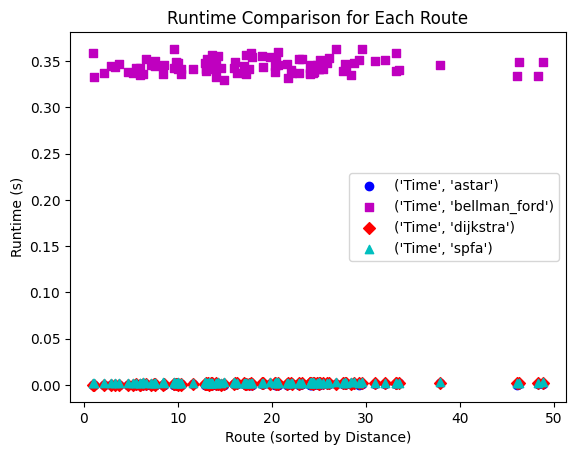

In [63]:
sorted_df = pivot_df.sort_values(by='Distance', ascending=True)
sorted_df.reset_index(drop=True, inplace=True)
colors = ['b', 'm', 'r', 'c', 'g', 'y', 'k']
markers = ['o', 's', 'D', '^', 'v']
for i, algorithm in enumerate(pivot_df.columns[4:8]):
    plt.scatter(sorted_df['Distance'], sorted_df[algorithm], marker=markers[i % len(markers)], color=colors[i % len(colors)], label=algorithm)
plt.title('Runtime Comparison for Each Route')
plt.xlabel('Route (sorted by Distance)')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

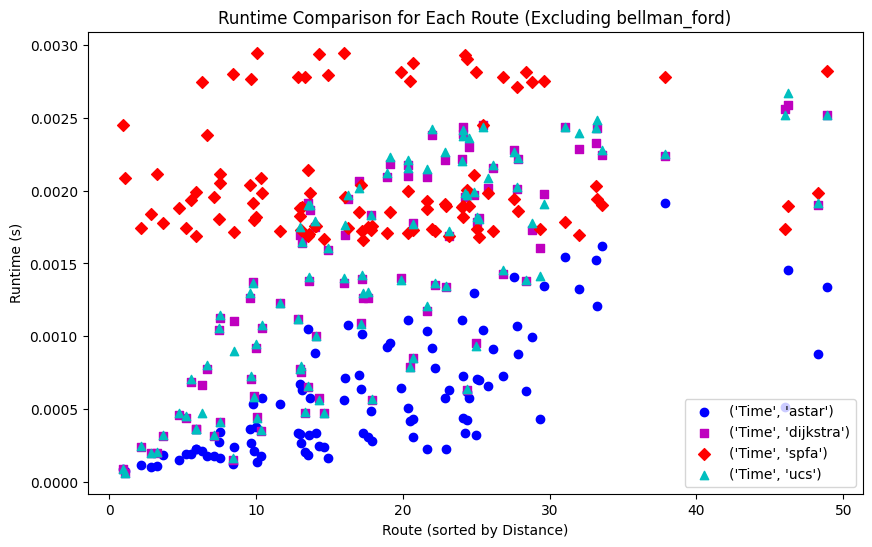

In [64]:
sorted_df = sorted_df.drop(('Time', 'bellman_ford'), axis=1)
plt.figure(figsize=(10, 6))
for i, algorithm in enumerate(sorted_df.columns[4:8]):
    plt.scatter(sorted_df['Distance'], sorted_df[algorithm], color=colors[i % len(colors)], marker=markers[i % len(markers)], label=algorithm)
plt.title('Runtime Comparison for Each Route (Excluding bellman_ford)')
plt.xlabel('Route (sorted by Distance)')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

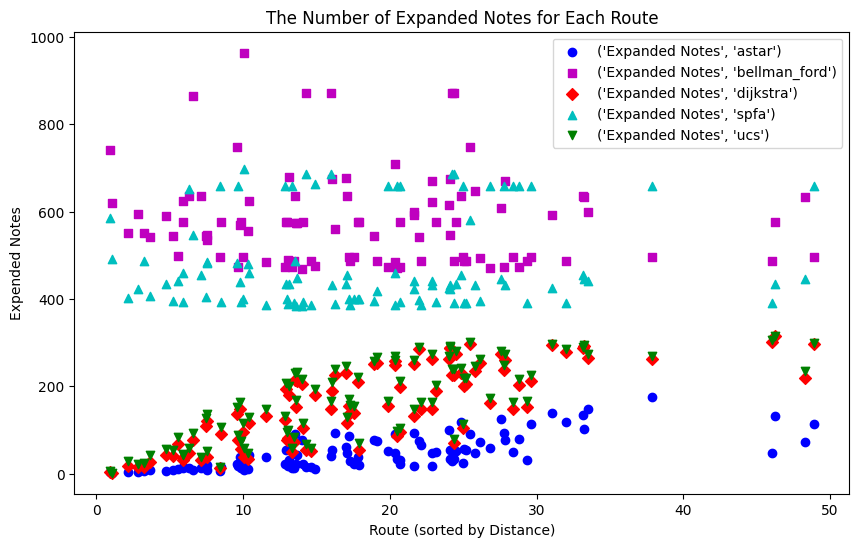

In [56]:
plt.figure(figsize=(10, 6))
for i, algorithm in enumerate(pivot_df.columns[9:14]):
    plt.scatter(sorted_df['Distance'], sorted_df[algorithm],marker=markers[i % len(markers)], color=colors[i % len(colors)], label=algorithm)
plt.title('The Number of Expanded Notes for Each Route')
plt.xlabel('Route (sorted by Distance)')
plt.ylabel('Expended Notes')
plt.legend()
plt.show()

In [26]:
algorithm = 'astar'
distance_functions = ['haversine', 'manhattan', 'euclidean', 'chebyshev']
results = []
for i in range(len(final_sample)):
    for distance_function in distance_functions:
        command1 = f"python find_shortest_path.py \"{final_sample.iloc[i,0]}\" \"{final_sample.iloc[i,1]}\" --algorithm {algorithm} --distance {distance_function}"
        result1 = subprocess.run(command1, shell=True, capture_output=True, text=True)
        
        output_lines1 = result1.stdout.strip().split('\n')
        time_info1 = output_lines1[0]  
        time_part1 = time_info1.split(':')[1].strip() 
        path_info1 = output_lines1[-2] 
        path_part1 = path_info1.split(':')[1].strip()
        distance_info1 = output_lines1[-1]  
        distance_part1 = distance_info1.split(':')[1].strip()
                
        result_dict1 = {
            'Distance Function': distance_function,
            'Start Station': final_sample.iloc[i,0],
            'End Station': final_sample.iloc[i,1],
            'Time': time_part1,
            'Path': path_part1,
            'Distance': distance_part1
        }
        results.append(result_dict1)

astar_diff = pd.DataFrame(results)
astar_diff.to_csv('results_diff_distance.csv', index=False)

In [27]:
astar_diff['Path Group'] = astar_diff.index // 4
# 使用groupby检查每个'Path Group'中的路径是否相同
path_comparison2 = astar_diff.groupby('Path Group')['Path'].nunique() == 1
all_same2 = all(path_comparison2)
if all_same2 == True:
    print("Once the two stations are fixed, all distance functions in a* algorithm get the same shortest path.")
else:
    print("Some distance functions get the different paths.")

Once the two stations are fixed, all distance functions in a* algorithm get the same shortest path.


In [28]:
if astar_diff['Distance'].dtype == 'O':
    astar_diff['Distance'] = astar_diff['Distance'].str.replace(' km', '')
astar_diff['Distance'] = pd.to_numeric(astar_diff['Distance'], errors='coerce')
astar_diff['Time'] = pd.to_numeric(astar_diff['Time'], errors='coerce')

pivot_distance = astar_diff.pivot(index=['Start Station', 'End Station', 'Path', 'Distance'],
                             columns='Distance Function', values=['Time']).reset_index()
pivot_distance = pivot_distance.reset_index(drop=True)
# one way ANOVA
f_val, p_val = f_oneway(pivot_distance[('Time','chebyshev')], pivot_distance[('Time','euclidean')],
                        pivot_distance[('Time','haversine')],pivot_distance[('Time','manhattan')])
if p_val < 0.05:
    print("Reject the null hypothesis that there are at least two distance functions that affect the algorithm's runtime.")
else:
    print("Accepting the null hypothesis, these four distance functions have approximately the same effect on the running time of the algorithm.")

Accepting the null hypothesis, these four distance functions have approximately the same effect on the running time of the algorithm.


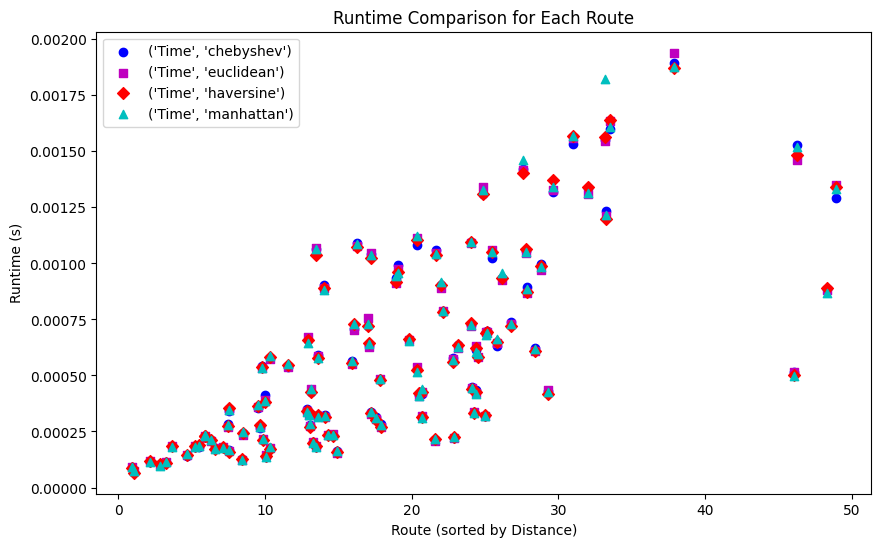

In [67]:
plt.figure(figsize=(10, 6))
for i, distance_function in enumerate(pivot_distance.columns[4:]):
    plt.scatter(pivot_distance['Distance'], pivot_distance[distance_function],marker=markers[i % len(markers)],  color=colors[i % len(colors)], label=distance_function)
plt.title('Runtime Comparison for Each Route')
plt.xlabel('Route (sorted by Distance)')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

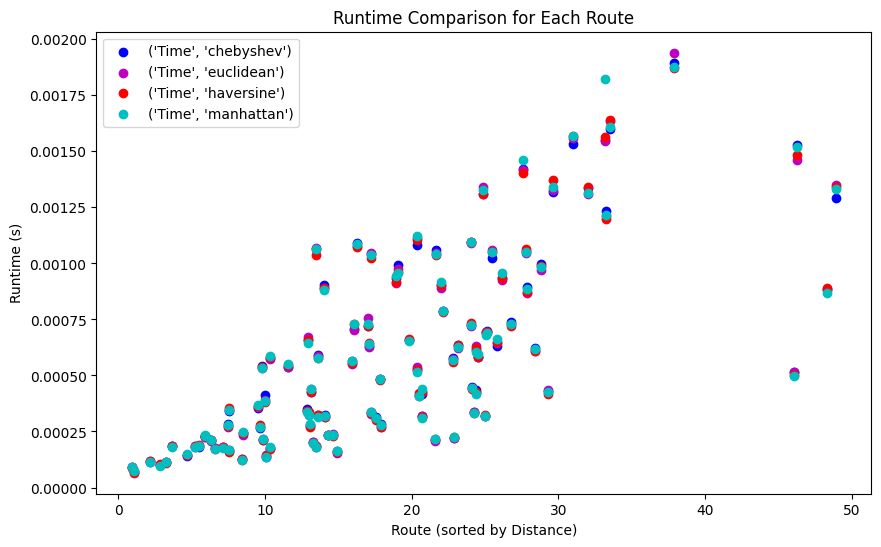

In [54]:
plt.figure(figsize=(10, 6))
colors = ['b', 'm', 'r', 'c', 'm', 'y', 'k']
for i, distance_function in enumerate(pivot_distance.columns[4:]):
    plt.scatter(pivot_distance['Distance'], pivot_distance[distance_function], marker='o',color=colors[i % len(colors)], label=distance_function)

plt.title('Runtime Comparison for Each Route')
plt.xlabel('Route (sorted by Distance)')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()